In [34]:
import numpy as np
from utils.distribution_geom import SamplerGeom
from utils.distribution_power_law import SamplerPowerLaw
from utils.distribution_super_exp import SamplerSuperExp

def set_phis_difusivo(N: int, phi: float, seed: int, dist: str):
    # generador de números aleatorios con distribución definida
    if dist == 'geom':
        sampler = SamplerGeom(p=0.5, tol=1e-14, seed=seed)
    elif dist == 'super_exp':  
        sampler = SamplerSuperExp(tol=1e-14, seed=seed)
    elif dist == 'power_law':
        sampler = SamplerPowerLaw(alpha=2.5, tol=1e-9, seed=seed)
    else:
        raise ValueError("Distribución no soportada: {}".format(dist))
        
    #Mitad de N como entero 
    total_segment_length = 0
    
    # Inicializar phis y l0
    phis: np.array = np.zeros(N)
    l0: np.array = np.zeros(N)
    
    # Inicializacion de orientación 
    orientation = 1

    i = 0
    while total_segment_length < N:
        if orientation == 1:
            orientation = -1
        else:
            orientation = 1
        
        rand = sampler.sample()
        i_temp = 0
        while i_temp < rand and total_segment_length < N:
            phis[i] = orientation
            l0[i] = 1.0
            total_segment_length += 1
            i += 1
            i_temp += 1
    
    phis = phis*phi 
    return phis, l0

phis, l0 = set_phis_difusivo(10, 1.0, 42, 'geom')

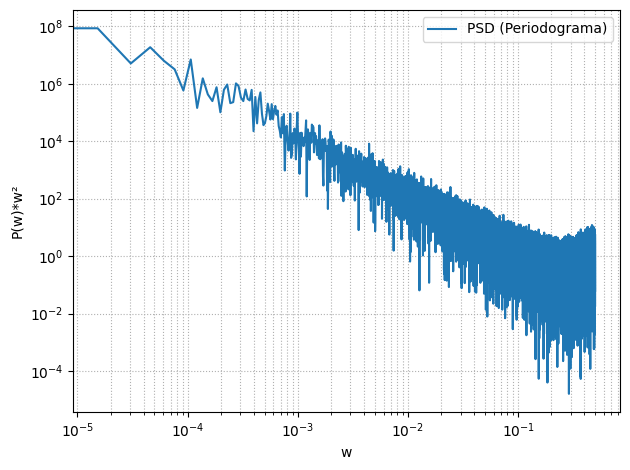

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

# ----------------------------
# Configuración
# ----------------------------
N   = 2**16          # número de pasos (grande para buen espectro)
fs  = 1.0            # "frecuencia" de muestreo (arbitraria)

# ----------------------------
# 1) Random walk con distribución señalada
# ----------------------------
steps = set_phis_difusivo(N, 1.0, 42, 'super_exp')[0]  
x = np.cumsum(steps)   # random walk


# ----------------------------
# 2) Periodograma unilateral (FFT)
# ----------------------------
def one_sided_psd_periodogram(x, fs):
    N = len(x)
    X = np.fft.rfft(x)                 # FFT unilateral
    Sxx = (np.abs(X)**2) / (fs * N)    # potencia/Hz
    # Conservar potencia en unilateral: duplicar bins salvo DC y Nyquist (si N par)
    if N % 2 == 0:
        Sxx[1:-1] *= 2.0
    else:
        Sxx[1:] *= 2.0
    f = np.fft.rfftfreq(N, d=1.0/fs)
    return f, Sxx

f_per, S_per = one_sided_psd_periodogram(x, fs)

# ----------------------------
# 3) Gráficos (log-log)
# ----------------------------
mask = f_per > 0

plt.figure()
plt.loglog(f_per, S_per , label="PSD (Periodograma)")
plt.xlabel("w")
plt.ylabel("P(w)*w²")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()
